In [1]:
import glob
import warnings
warnings.filterwarnings('ignore')
from osgeo import gdal
from shapely import wkt
from typing import *
%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

import rasterio
from torch.utils.tensorboard import SummaryWriter
import skimage
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union
import solaris as sol

from tqdm import tqdm
import tifffile as sktif

import geopandas as gpd
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *
import ujson as json
from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"
from importlib import reload

env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


W1117 21:34:46.631498 139756830218048 deprecation_wrapper.py:119] From /home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/solaris/nets/metrics.py:103: The name tf.keras.metrics.cosine_proximity is deprecated. Please use tf.keras.losses.cosine_similarity instead.

W1117 21:34:46.671791 139756830218048 deprecation_wrapper.py:119] From /home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/solaris/nets/_keras_losses.py:104: The name tf.keras.losses.cosine is deprecated. Please use tf.keras.losses.cosine_similarity instead.



In [2]:
data_dir = Path("/media/wwymak/Storage/xView2")
mask_dir = data_dir /"mask_full_size"

train_images_crops = data_dir/"train_crops"
# train_mask_crops = data_dir/"mask_crops"
train_mask_crops = data_dir/"mask_crops_single_channel"

In [3]:
unique_img_ids = list(set([x.name.replace('mask_', '').split('.')[0] for x in train_mask_crops.ls() ]))
np.random.seed(42)
np.random.shuffle(unique_img_ids)
train_ids = unique_img_ids[:int(0.8 * len(unique_img_ids))]
valid_ids = unique_img_ids[int(0.8 * len(unique_img_ids)):]

In [4]:
def is_valid_func(fname):
    
    img_id = Path(fname).name.replace('rgb_', '').split('.')[0]

    return img_id in valid_ids

def get_mask_fn(fname):
    return train_mask_crops / fname.name.replace("rgb", "mask")

def show_examples(name: str, image: np.ndarray, mask: np.ndarray):
    plt.figure(figsize=(10, 14))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {name}")

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title(f"Mask: {name}")


def show(index: int, images: List[Path], masks: List[Path], transforms=None) -> None:
    image_path = images[index]
    name = image_path.name

    image = np.array(Image.open(image_path))
    mask = np.array(Image.open(masks[index]))

    if transforms is not None:
        temp = transforms(image=image, mask=mask)
        image = temp["image"]
        mask = temp["mask"]

    show_examples(name, image, mask)

def show_random(images: List[Path], masks: List[Path], transforms=None) -> None:
    length = len(images)
    index = random.randint(0, length - 1)
    show(index, images, masks, transforms)

In [5]:
size=256
bs=16
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

src = (SegItemListCustom.from_folder(train_images_crops)
      .split_by_valid_func(is_valid_func)
       .label_from_func(get_mask_fn, classes=['void', 'building']))

data = (src.transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

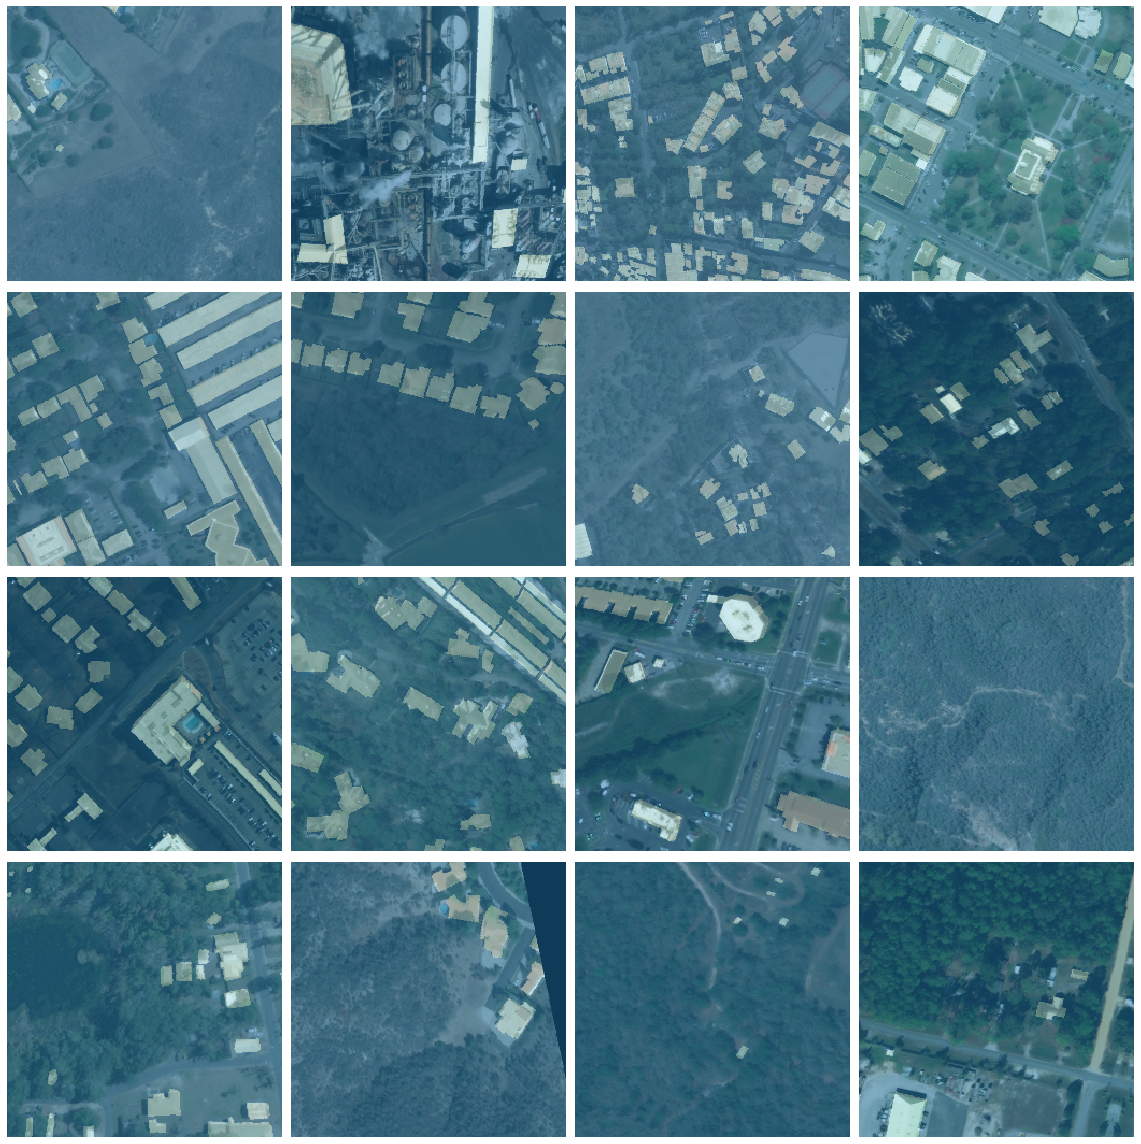

In [6]:
data.show_batch()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


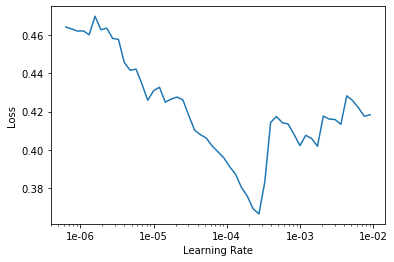

In [7]:
accuracy_pixel=partial(foreground_acc, void_code=0)
f1_score = partial(fbeta, thresh=0.2, beta = 1)

wd =1e-2

metrics = [accuracy_pixel,f1_score, dice]
learn = unet_learner(data, models.resnet34, metrics=metrics)
learn.to_fp16();
learn.lr_find()
learn.recorder.plot()

In [8]:
lr=1e-4
models_path = data_dir / "models"
learn.model_dir = models_path
callbacks=[SaveModelCallback(learn, every='improvement', monitor='f1_score', name='xview_buildings_default_unet'),
#           TerminateOnNaNCallback(),
           ReduceLROnPlateauCallback(learn, patience=1)
          ]

learn.fit_one_cycle(5, slice(lr), callbacks=callbacks)

epoch,train_loss,valid_loss,foreground_acc,fbeta,dice,time
0,0.147539,0.149602,0.596682,0.127113,0.650707,03:21
1,0.114404,0.116362,0.643218,0.122957,0.719865,03:22
2,0.104619,0.107292,0.724788,0.119827,0.760359,03:34
3,0.103073,0.104107,0.757619,0.117385,0.773364,03:36
4,0.096587,0.101224,0.741094,0.118100,0.774051,03:32


In [9]:
learn.save('17Nov-xview_buildings_default_unet')

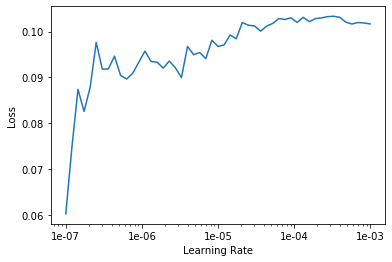

In [14]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(skip_start=0);

In [15]:
lr=1e-7
models_path = data_dir / "models"
learn.model_dir = models_path
learn.metrics =  [accuracy_pixel, dice]
callbacks=[SaveModelCallback(learn, every='improvement', monitor='dice', name='17Nov-xview_buildings_default_unet-unfrozen'),
#           TerminateOnNaNCallback(),
           ReduceLROnPlateauCallback(learn, patience=2)
          ]

learn.fit_one_cycle(5, slice(lr), callbacks=callbacks)

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.102330,0.101555,0.744289,0.774450,03:49
1,0.097777,0.101131,0.742970,0.774716,03:48
2,0.096806,0.101876,0.751469,0.775496,03:46
3,0.099315,0.101631,0.742366,0.773783,03:47
4,0.096544,0.101369,0.748340,0.775552,03:37


Better model found at epoch 0 with dice value: 0.7744495868682861.
Better model found at epoch 1 with dice value: 0.7747163772583008.
Better model found at epoch 2 with dice value: 0.7754964232444763.
Better model found at epoch 4 with dice value: 0.7755520939826965.
Epoch 4: reducing lr to 8e-14


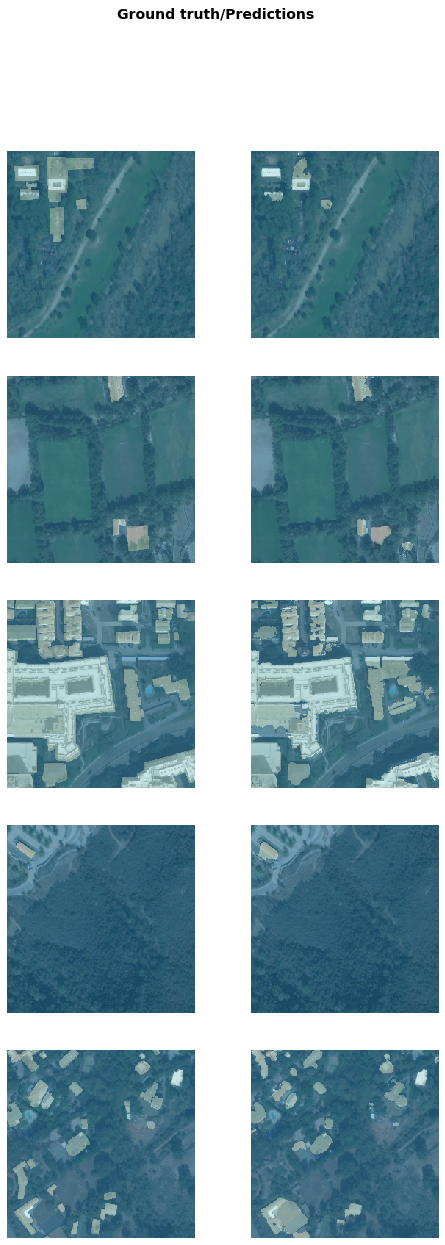

In [16]:
learn.show_results()